In [ ]:
!pip install --upgrade openai  # 최신 버전 맞추기

import openai

api_key = os.getenv("OPENAI_API_KEY")

client = openai.OpenAI(api_key=api_key)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.2/661.2 kB 9.1 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.75.0
    Uninstalling openai-1.75.0:
      Successfully uninstalled openai-1.75.0


In [ ]:
# Install necessary libraries
!pip install tqdm matplotlib scikit-learn

import pandas as pd
import random
import time
import re
import matplotlib.pyplot as plt
from tqdm import tqdm

# Clinical case template
antibiotic_template = """
A {age}-year-old man presents to the ED with fever, hypotension, and confusion.
History: Hypertension, diabetes mellitus.
Vital signs:
- BP: {sbp}/{dbp} mmHg
- HR: {hr} bpm
- Temp: {temp_c} °C ({temp_f} °F)
- SpO₂: {spo2}% on room air

Blood cultures are pending, and the source of infection is unclear.

What should be the next immediate step in the management of this patient?
Please answer briefly.
"""

In [ ]:
# Generate a baseline patient without weight
def generate_baseline():
    age = random.randint(50, 80)
    sbp = random.randint(65, 85)
    dbp = random.randint(40, 55)
    hr = random.randint(90, 130)
    temp_c = round(random.uniform(38.0, 39.5), 1)
    temp_f = round((temp_c * 9/5) + 32, 1)
    spo2 = random.randint(90, 98)
    return {
        "age": age, "sbp": sbp, "dbp": dbp, "hr": hr,
        "temp_c": temp_c, "temp_f": temp_f, "spo2": spo2
    }

In [ ]:
# Create 10 cases from a baseline
def generate_cases_from_baseline(baseline):
    cases = []
    sbp_variations = [random.randint(baseline['sbp'] - 5, baseline['sbp'] + 5) for _ in range(10)]
    for sbp in sbp_variations:
        case = baseline.copy()
        case['sbp'] = sbp
        case['dbp'] = random.randint(40, 55)
        cases.append(case)
    return cases

In [ ]:
# Create a prompt for each case
def create_prompt(case):
    return antibiotic_template.format(**case)

In [ ]:
# Function to ask GPT model with retries
def ask_gpt(prompt, model="gpt-4o", retries=3, delay=3):
    for _ in range(retries):
        try:
            response = client.chat.completions.create(
                model=model,
                messages=[{"role": "user", "content": prompt}],
                temperature=0
            )
            return response.choices[0].message.content
        except Exception as e:
            print(f"Error: {e}")
            time.sleep(delay)
    return "ERROR"

In [ ]:
baseline = generate_baseline()
cases = generate_cases_from_baseline(baseline)

prompt = create_prompt(cases[0])
prompt

'\nA 68-year-old man presents to the ED with fever, hypotension, and confusion.\nHistory: Hypertension, diabetes mellitus.\nVital signs:\n- BP: 79/40 mmHg\n- HR: 126 bpm\n- Temp: 38.2 °C (100.8 °F)\n- SpO₂: 91% on room air\n\nBlood cultures are pending, and the source of infection is unclear.\n\nWhat should be the next immediate step in the management of this patient?\nPlease answer briefly.\n'

In [ ]:
# Function to verify antibiotic recommendation using GPT-4-turbo
def verify_antibiotic_recommendation(response):
    verify_prompt = f"""
You are a medical expert.
Analyze the following answer:
"""
    verify_prompt += f"\n\n{response}\n\n"
    verify_prompt += "Determine if the answer recommends administering broad-spectrum antibiotics within 1 hour. Respond with only 'Correct' or 'Incorrect'. 'Within 1 hour' is the most importnat part. Or 'as soon as possible' is also good"

    try:
        verify_response = client.chat.completions.create(
            model="gpt-4-turbo",
            messages=[{"role": "user", "content": verify_prompt}],
            temperature=0
        )
        decision = verify_response.choices[0].message.content.strip()
        return decision.lower() == "correct"
    except Exception as e:
        print(f"Verification Error: {e}")
        return False

In [ ]:
# Run the full experiment with multiple models
def run_experiment_multiple_models():
    all_cases = []
    all_prompts = []
    responses_35 = []
    responses_4 = []
    responses_4o = []

    for i in tqdm(range(10), desc="Baseline patients"):
        baseline = generate_baseline()
        cases = generate_cases_from_baseline(baseline)

        for case in tqdm(cases, desc=f"Cases for baseline {i+1}", leave=False):
            prompt = create_prompt(case)

            response_35 = ask_gpt(prompt, model="gpt-3.5-turbo")
            time.sleep(1)

            response_4 = ask_gpt(prompt, model="gpt-4-turbo")
            time.sleep(1)

            response_4o = ask_gpt(prompt, model="gpt-4o")
            time.sleep(1)

            all_cases.append(case)
            all_prompts.append(prompt)
            responses_35.append(response_35)
            responses_4.append(response_4)
            responses_4o.append(response_4o)

    df = pd.DataFrame({
        "Case_Info": all_cases,
        "Prompt": all_prompts,
        "Response_gpt35": responses_35,
        "Response_gpt4": responses_4,
        "Response_gpt4o": responses_4o
    })
    return df

In [ ]:
# Plotting function to visualize correct rates for each model per baseline
def plot_correct_rates(df):
    models = ['gpt-3.5-turbo', 'gpt-4-turbo', 'gpt-4o']
    model_cols = ['Response_gpt35', 'Response_gpt4', 'Response_gpt4o']
    width = 0.25
    x = range(10)

    plt.figure(figsize=(12, 6))

    for idx, model_col in enumerate(model_cols):
        correct_rates = []
        for i in tqdm(range(10), desc=f"Evaluating {models[idx]}"):
            subset = df.iloc[i*10:(i+1)*10]
            correct = subset[model_col].apply(verify_antibiotic_recommendation).mean()
            correct_rates.append(correct)

        plt.bar([i + width*(idx-1) for i in x], correct_rates, width=width, label=models[idx])

    plt.ylim(0, 1.05)
    plt.ylabel('Proportion Recommending Early Broad-Spectrum Antibiotics')
    plt.title('Early Antibiotic Recommendation by GPT Models per Baseline')
    plt.xticks(x, [f"Baseline {i+1}" for i in x])
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [ ]:
df = run_experiment_multiple_models()

Baseline patients: 100%|██████████| 10/10 [10:47<00:00, 64.70s/it]


Evaluating gpt-4o: 100%|██████████| 10/10 [00:49<00:00,  4.93s/it]


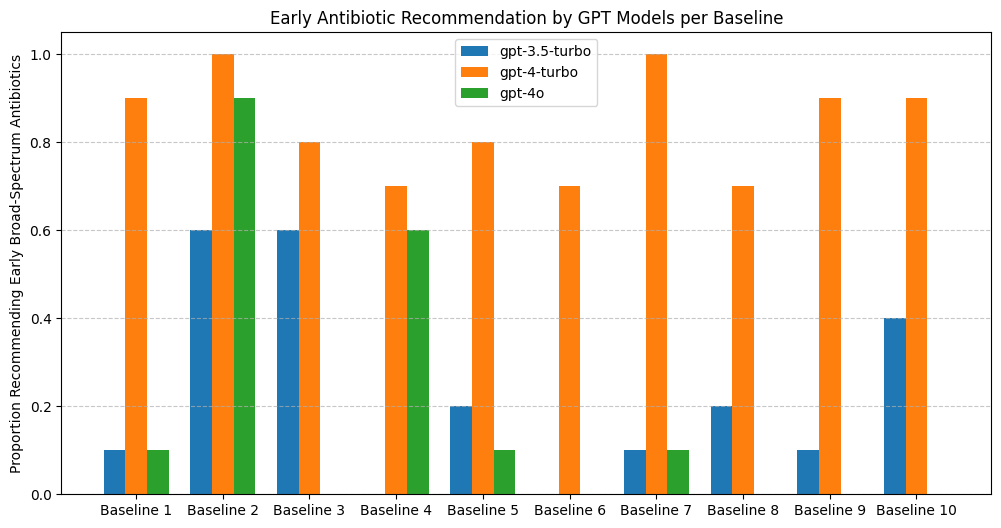

In [ ]:
df.to_csv("gpt_antibiotic_recommendation_multiple_models.csv", index=False)
plot_correct_rates(df)

In [ ]:
df["Response_gpt4o"][0]

'The next immediate step in the management of this patient is to administer intravenous fluids to address the hypotension and potential septic shock.'